In [12]:
import ROOT
import os
import time
import matplotlib.pyplot as plt
import csv
import uproot

Welcome to JupyROOT 6.24/06


In [15]:
path = "../data/128_files/"

In [3]:
def get_total_size(path, n_files):
    filenames = sorted(os.listdir(path))
    total_size = sum([os.path.getsize(path + filenames[i]) for i in range(n_files)])
    return total_size / (2**30)

In [4]:
def get_total_entries(path, n_files):
    filenames = sorted(os.listdir(path))[:n_files]
    total_entries = sum([uproot.open(path + filename + ":rootuple/CandidateTree").num_entries for filename in filenames])
    return total_entries

In [5]:
def col_average(data):
    n_rows = len(data)
    n_cols = len(data[0])
    return [sum([data[i][j] for i in range(1, n_rows)]) / (n_rows - 1) for j in range(n_cols)]

In [6]:
def col_standard_deviation(data):
    n_rows = len(data)
    n_cols = len(data[0])
    mean = col_average(data)
    return [(sum([(data[i][j] - mean[j])**2 for i in range(1, n_rows)]) / (n_rows - 1))**0.5 for j in range(n_cols)]
    

In [28]:
def runtime_measure(path, n_files):
    # Specify the number of threads
    ROOT.ROOT.EnableImplicitMT()
    
    # Get paths to all the files to be read 
    filenames = sorted(os.listdir(path))
    files_to_read = ROOT.std.vector('string')()
    for i in range(n_files):
        files_to_read.push_back(path + filenames[i])
    
    # Measure runtime
    start_time = time.time()
    data = ROOT.RDataFrame("rootuple/CandidateTree", files_to_read)
    cut = data.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")\
          .Filter("candidate_vMass > 5.33")\
          .Filter("candidate_vMass < 5.40")
    np_array = cut.AsNumpy(["candidate_vMass"])
    runtime = time.time() - start_time
    
    return runtime
    

In [8]:
import multiprocessing
import numpy as np
import concurrent.futures

In [19]:
def to_numpy(files, result):
#     ROOT.ROOT.DisableImplicitMT()
    data = ROOT.RDataFrame("rootuple/CandidateTree", files)
    cut = data.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")\
          .Filter("candidate_vMass > 5.33")\
          .Filter("candidate_vMass < 5.40")
    result.append(cut.AsNumpy(["candidate_vMass"])["candidate_vMass"])


In [10]:
def partition_files(path, n_files, n_processes):
    filenames = sorted(os.listdir(path))
    partitions = []
    sizes = []
    temp = 0
    for i in range(n_processes):
        if i >= n_files: break
        n_files_in_partition = n_files // n_processes if i >= n_files % n_processes else n_files // n_processes + 1
        files_to_read = ROOT.std.vector('string')()
        partition_size = 0
        for j in range(n_files_in_partition):
            files_to_read.push_back(path + filenames[temp + j])
            partition_size += os.path.getsize(path + filenames[temp + j]) / 2**30
        temp += n_files_in_partition
        partitions.append(files_to_read)
        sizes.append(partition_size)
    return partitions, sizes

In [13]:
def runtime_measure_mp(path, n_files, n_processes):
    # Measure runtime
    partitions, _ = partition_files(path, n_files, n_processes)
    start_time = time.time()
    processes = []
    result = multiprocessing.Manager().list()
    for partition in partitions:
        p = multiprocessing.Process(target=to_numpy, args=[partition, result])
        p.start()
        processes.append(p)
        
    for p in processes:
        p.join()
     
    np.concatenate(tuple(result))
    runtime = time.time() - start_time
    
    return runtime


In [29]:
runtime_measure(path, 4)

24.481698989868164

In [15]:
def runtime_vs_size(path, n_threads, max_files, step, n_loops, target_dir):
    result_path = ("runtime_tests_rdf/%s/runtime_vs_size_%d_%d_%d_%d.csv" % (target_dir, n_threads, max_files, step, n_loops))
    x = [get_total_size(path, a) for a in range(step, max_files + step, step)]
    with open(result_path, "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(n_loops):
        y = [runtime_measure(path, i, n_threads) for i in range(step, max_files + step, step)]
        with open(result_path, "a+", newline="") as f:
            csv.writer(f).writerow(y)


In [16]:
def runtime_vs_size_plot(path, n_threads, max_files, step, n_loops, target_dir):
    if not os.path.exists("runtime_tests_rdf/%s" % (target_dir)):
        os.mkdir("runtime_tests_rdf/%s" % (target_dir))
    if not os.path.exists("figures/rdf/%s" % (target_dir)):
        os.mkdir("figures/rdf/%s" % (target_dir))
    result_path = ("runtime_tests_rdf/%s/runtime_vs_size_%d_%d_%d_%d.csv" % (target_dir, n_threads, max_files, step, n_loops))
    if not os.path.exists(result_path):
        runtime_vs_size(path, n_threads, max_files, step, n_loops, target_dir)
    with open(result_path, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (15, 5))
        plt.title('Runtime vs Size (%d threads)' % (n_threads))
        plt.xlabel('Size (GB)')
        plt.ylabel('Runtime (s)')
        #plt.scatter(data[0], col_average(data))
        #for r in range(1, len(data)):
            #plt.scatter(data[0], data[r])
        plt.errorbar(data[0], col_average(data), yerr=col_standard_deviation(data), fmt="o", ecolor="orange")
        plt.savefig('figures/rdf/%s/runtime_vs_size_%d_%d_%d_%d.png' % (target_dir, n_threads, max_files, step, n_loops), bbox_inches='tight')


In [17]:
def runtime_vs_threads(path, n_files, max_threads, step, n_loops, target_dir):
    parent_dir = path.split('/')[-2]
    result_path = ("runtime_tests_rdf/%s/runtime_vs_threads_%d_%d_%d_%d.csv" % (target_dir, n_files, max_threads, step, n_loops))
    x = [a for a in range(step, max_threads + step, step)]
    with open(result_path, "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(n_loops):
        y = [runtime_measure(path, n_files, i) for i in range(step, max_threads + step, step)]
        with open(result_path, "a+", newline="") as f:
            csv.writer(f).writerow(y)
        

In [18]:
def runtime_vs_threads_plot(path, n_files, max_threads, step, n_loops, target_dir):
    parent_dir = path.split('/')[-2]
    if not os.path.exists("runtime_tests_rdf/%s" % (target_dir)):
        os.mkdir("runtime_tests_rdf/%s" % (target_dir))
    if not os.path.exists("figures/rdf/%s" % (target_dir)):
        os.mkdir("figures/rdf/%s" % (target_dir))
    result_path = ("runtime_tests_rdf/%s/runtime_vs_threads_%d_%d_%d_%d.csv" % (target_dir, n_files, max_threads, step, n_loops))
    if not os.path.exists(result_path):
        runtime_vs_threads(path, n_files, max_threads, step, n_loops, target_dir)
    with open(result_path, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (15, 5))
        plt.title('Runtime vs Threads (%.2f GB)' % (get_total_size(path, n_files)))
        plt.xlabel('Threads')
        plt.ylabel('Runtime (s)')
        #plt.scatter(data[0], col_average(data))
        #for r in range(1, len(data)):
            #plt.scatter(data[0], data[r])
        plt.xticks(range(step, max_threads + 1, step))
        plt.gca().set_ylim([0, 50])
        plt.errorbar(data[0], col_average(data[:]), yerr=col_standard_deviation(data[:]), fmt="o", ecolor="orange")
        for i in range(len(data[0])): 
            plt.annotate(round(col_average(data[:])[i], 2), (data[0][i], col_average(data[:])[i]))
        plt.savefig('figures/rdf/%s/runtime_vs_threads_%d_%d_%d_%d.png' % (target_dir, n_files, max_threads, step, n_loops), bbox_inches='tight')

In [19]:
def runtime_vs_processes(path, n_files, step, n_loops, target_dir):
    parent_dir = path.split('/')[-2]
    result_path = ("runtime_tests_rdf/%s/runtime_vs_processes_%d_%d_%d.csv" % (target_dir, n_files, step, n_loops))
    x = [a for a in range(step, n_files + step, step)]
    with open(result_path, "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(n_loops):
        y = [runtime_measure_mp(path, n_files, i) for i in range(step, n_files + step, step)]
        with open(result_path, "a+", newline="") as f:
            csv.writer(f).writerow(y)

In [20]:
def runtime_vs_processes_plot(path, n_files, step, n_loops, target_dir):
    parent_dir = path.split('/')[-2]
    if not os.path.exists("runtime_tests_rdf/%s" % (target_dir)):
        os.mkdir("runtime_tests_rdf/%s" % (target_dir))
    if not os.path.exists("figures/rdf/%s" % (target_dir)):
        os.mkdir("figures/rdf/%s" % (target_dir))
    result_path = ("runtime_tests_rdf/%s/runtime_vs_processes_%d_%d_%d.csv" % (target_dir, n_files, step, n_loops))
    if not os.path.exists(result_path):
        runtime_vs_processes(path, n_files, step, n_loops, target_dir)
    with open(result_path, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (20, 8))
        plt.title('Runtime vs Processes (%d files, %.2f GB)' % (n_files, get_total_size(path, n_files)))
        plt.xlabel('Processes')
        plt.ylabel('Runtime (s)')
        #plt.scatter(data[0], col_average(data))
        #for r in range(1, len(data)):
            #plt.scatter(data[0], data[r])
        plt.xticks(range(step, n_files + 1, step))
        plt.errorbar(data[0], col_average(data[:]), yerr=col_standard_deviation(data[:]), fmt="o", ecolor="orange")
        for i in range(len(data[0])): 
            plt.annotate(round(col_average(data[:])[i], 2), (data[0][i], col_average(data[:])[i]))
        plt.savefig('figures/rdf/%s/runtime_vs_processes_%d_%d_%d.png' % (target_dir, n_files, step, n_loops), bbox_inches='tight')

In [21]:
def runtime_vs_size_mp(path, n_processes, max_files, step, n_loops, target_dir):
    result_path = ("runtime_tests_rdf/%s/runtime_vs_size_mp_%d_%d_%d_%d.csv" % (target_dir, n_processes, max_files, step, n_loops))
    x = [get_total_size(path, a) for a in range(step, max_files + step, step)]
    with open(result_path, "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(n_loops):
        y = [runtime_measure_mp(path, i, n_processes) for i in range(step, max_files + step, step)]
        with open(result_path, "a+", newline="") as f:
            csv.writer(f).writerow(y)

In [22]:
def runtime_vs_size_plot_mp(path, n_processes, max_files, step, n_loops, target_dir):
    if not os.path.exists("runtime_tests_rdf/%s" % (target_dir)):
        os.mkdir("runtime_tests_rdf/%s" % (target_dir))
    if not os.path.exists("figures/rdf/%s" % (target_dir)):
        os.mkdir("figures/rdf/%s" % (target_dir))
    result_path = ("runtime_tests_rdf/%s/runtime_vs_size_mp_%d_%d_%d_%d.csv" % (target_dir, n_processes, max_files, step, n_loops))
    if not os.path.exists(result_path):
        runtime_vs_size_mp(path, n_processes, max_files, step, n_loops, target_dir)
    with open(result_path, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (20, 8))
        plt.title('Runtime vs Size (%d processes)' % (n_processes))
        plt.xlabel('Size (GB)')
        plt.ylabel('Runtime (s)')
        #plt.scatter(data[0], col_average(data))
        #for r in range(1, len(data)):
            #plt.scatter(data[0], data[r])
        plt.errorbar(data[0], col_average(data[1:]), yerr=col_standard_deviation(data[1:]), fmt="o", ecolor="orange")
        for i in range(len(data[0])): 
            plt.annotate("%.2f(%d)" % (round(col_average(data[1:])[i], 2), (i + 1) * step), (data[0][i], col_average(data[1:])[i]))
        plt.savefig('figures/rdf/%s/runtime_vs_size_mp_%d_%d_%d_%d.png' % (target_dir, n_processes, max_files, step, n_loops), bbox_inches='tight')

In [19]:
#runtime_vs_threads_plot(path, 10, 10, 1, 10, "merged")


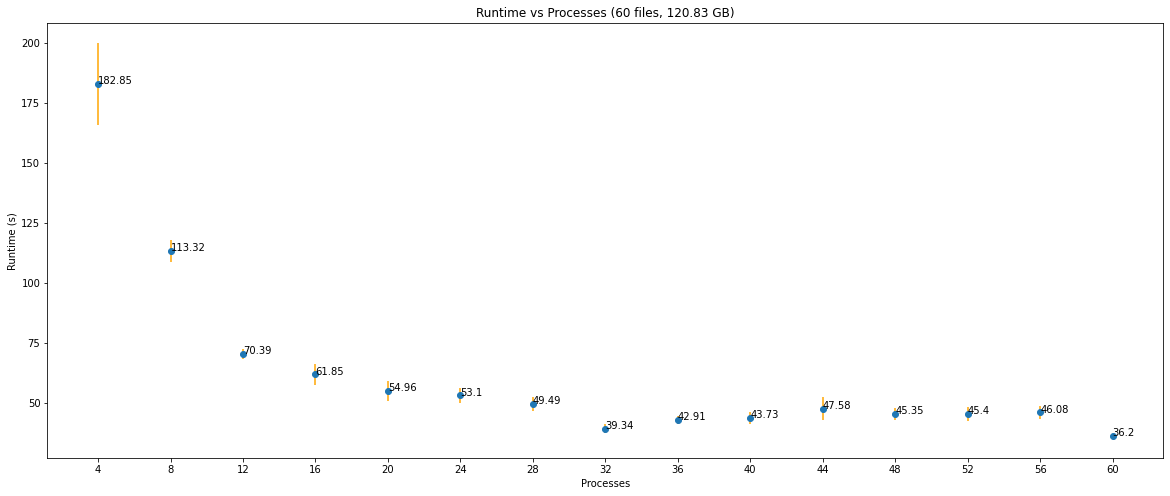

In [46]:
runtime_vs_processes_plot(path, 60, 4, 10, "merged")

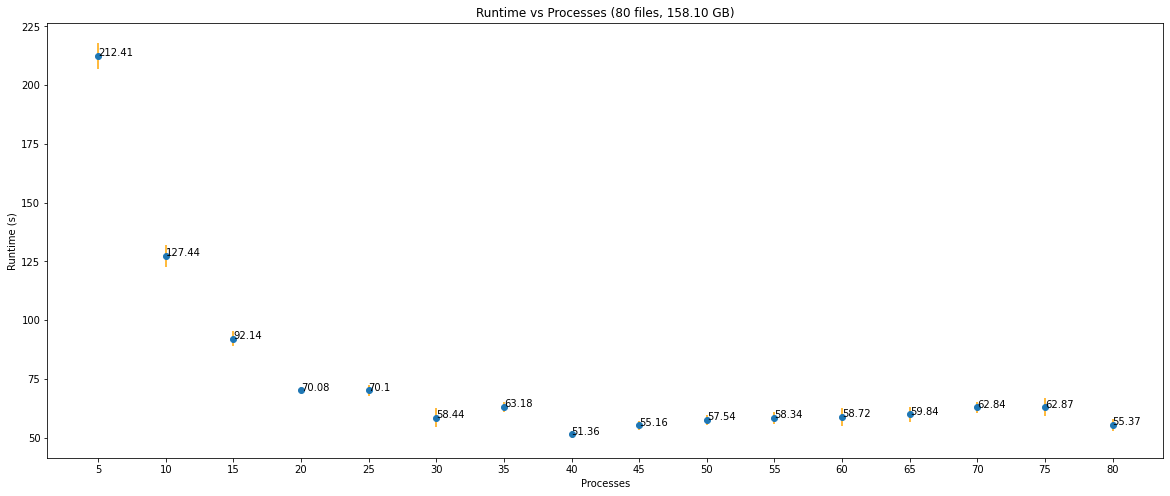

In [47]:
runtime_vs_processes_plot(path, 80, 5, 10, "merged")

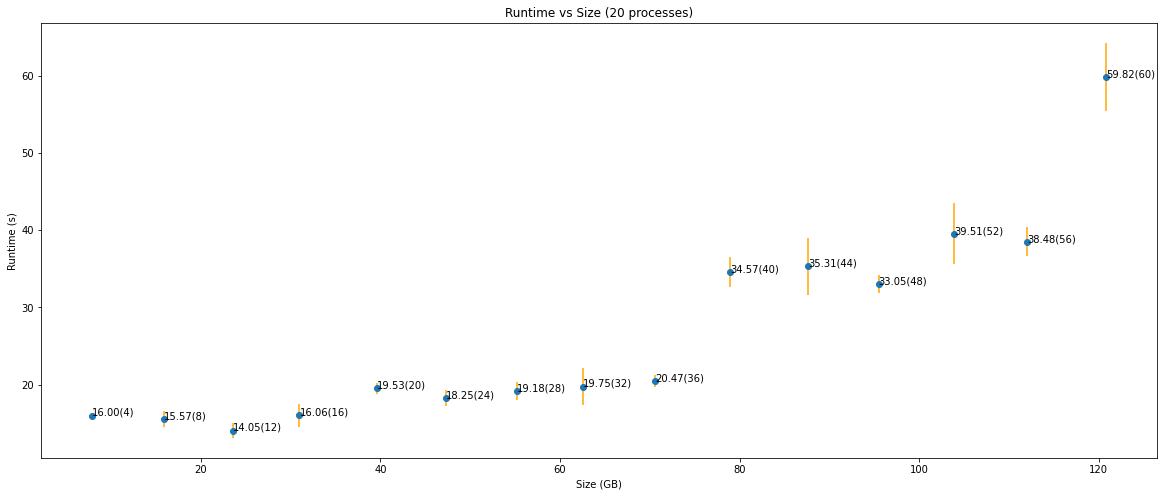

In [49]:
runtime_vs_size_plot_mp(path, 20, 60, 4, 10, "merged")

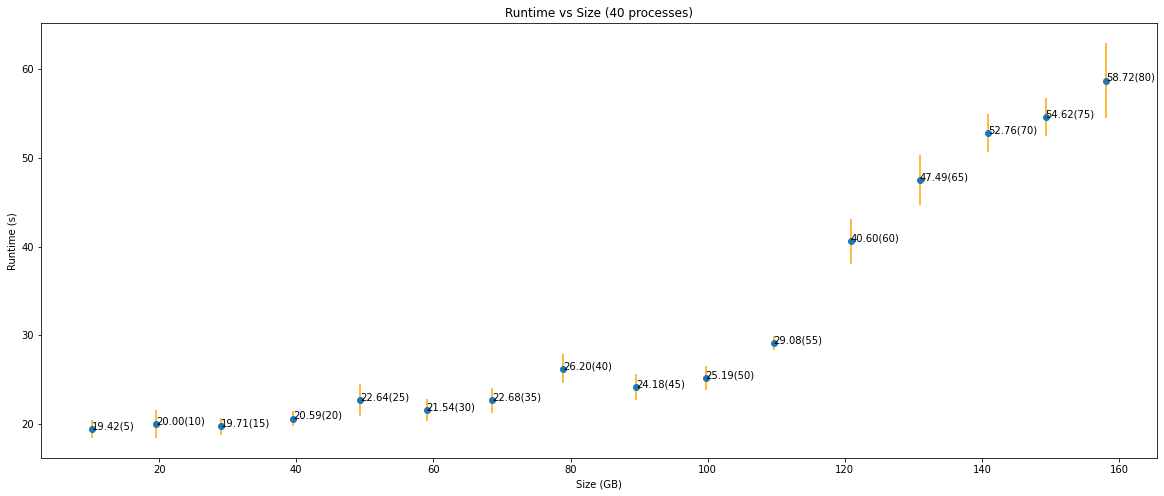

In [50]:
runtime_vs_size_plot_mp(path, 40, 80, 5, 10, "merged")

In [176]:
def to_numpy_detailed(files, size, index, result, process_runtimes):
    if files.empty(): return
    key = "P%d (%.2f GB)" % (index, size)
    start_time = time.time()
    data = ROOT.RDataFrame("rootuple/CandidateTree", files)
    cut = data.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")\
          .Filter("candidate_vMass > 5.33")\
          .Filter("candidate_vMass < 5.40")
    result.append(cut.AsNumpy(["candidate_vMass"])["candidate_vMass"])
    runtime = time.time() - start_time
    
    process_runtimes[key] = runtime
#     if key not in process_runtimes.keys():
#         process_runtimes[key] = [runtime]
#     else:
#         process_runtimes[key].append(runtime)

In [177]:
def runtime_measure_detailed(path, n_files, n_processes):
    partitions, sizes = partition_files(path, n_files, n_processes)
    start_time = time.time()
    processes = []
    result = multiprocessing.Manager().list()
    process_runtimes = multiprocessing.Manager().dict()
    for i in range(len(partitions)):
        p = multiprocessing.Process(target=to_numpy_detailed, args=[partitions[i], sizes[i], i, result, process_runtimes])
        p.start()
        processes.append(p)
        
    for p in processes:
        p.join()
     
    start_concat = time.time()
    np.concatenate(tuple(result))
    concat_runtime = time.time() - start_concat
    
    runtime = time.time() - start_time
    
    return runtime, concat_runtime, dict(process_runtimes)

In [206]:
runtime_measure_detailed(path, 4, 4)

(8.298522472381592,
 0.03396868705749512,
 {'P0 (1.58 GB)': 4.222818374633789,
  'P1 (1.71 GB)': 4.618277311325073,
  'P2 (2.01 GB)': 5.395500183105469,
  'P3 (2.53 GB)': 7.683523178100586})

In [207]:
runtime_measure_detailed(path, 8, 8)

(8.368515253067017,
 0.06996965408325195,
 {'P0 (1.58 GB)': 5.059680223464966,
  'P1 (1.71 GB)': 5.60768985748291,
  'P5 (1.88 GB)': 5.777304410934448,
  'P7 (1.74 GB)': 5.8979103565216064,
  'P6 (2.13 GB)': 6.5603015422821045,
  'P2 (2.01 GB)': 6.98445987701416,
  'P4 (2.33 GB)': 7.069056034088135,
  'P3 (2.53 GB)': 7.564417362213135})

In [208]:
runtime_measure_detailed(path, 8, 4)

(14.133344888687134,
 0.029072284698486328,
 {'P0 (3.28 GB)': 9.409071683883667,
  'P3 (3.87 GB)': 11.5398268699646,
  'P1 (4.54 GB)': 12.478398084640503,
  'P2 (4.21 GB)': 13.667912006378174})

In [211]:
runtime_measure_detailed(path, 16, 16)

(9.500199794769287,
 0.12238478660583496,
 {'P0 (1.58 GB)': 5.680706739425659,
  'P12 (1.37 GB)': 5.021839618682861,
  'P1 (1.71 GB)': 6.160112380981445,
  'P9 (1.62 GB)': 5.948520183563232,
  'P7 (1.74 GB)': 6.4374237060546875,
  'P5 (1.88 GB)': 6.890300035476685,
  'P2 (2.01 GB)': 7.166510343551636,
  'P11 (1.92 GB)': 6.8787617683410645,
  'P15 (1.93 GB)': 6.557844638824463,
  'P10 (2.05 GB)': 7.181875944137573,
  'P8 (2.05 GB)': 7.524121284484863,
  'P3 (2.53 GB)': 8.025259733200073,
  'P6 (2.13 GB)': 7.785608768463135,
  'P14 (2.02 GB)': 6.973600149154663,
  'P4 (2.33 GB)': 8.394427299499512,
  'P13 (2.10 GB)': 7.6181745529174805})

In [210]:
runtime_measure_detailed(path, 16, 8)

(14.705524206161499,
 0.03705954551696777,
 {'P0 (3.28 GB)': 10.141327381134033,
  'P6 (3.48 GB)': 9.70118260383606,
  'P4 (3.68 GB)': 11.04108738899231,
  'P5 (3.97 GB)': 11.544242143630981,
  'P1 (4.54 GB)': 12.628660202026367,
  'P3 (3.87 GB)': 12.688769817352295,
  'P7 (3.95 GB)': 12.789910078048706,
  'P2 (4.21 GB)': 14.18796992301941})

In [220]:
runtime_measure_detailed(path, 64, 64)

(41.84435701370239,
 0.3766934871673584,
 {'P12 (1.37 GB)': 9.306405544281006,
  'P0 (1.58 GB)': 10.43319034576416,
  'P14 (2.02 GB)': 12.206387281417847,
  'P6 (2.13 GB)': 13.806394100189209,
  'P8 (2.05 GB)': 13.680728197097778,
  'P4 (2.33 GB)': 14.035703182220459,
  'P30 (1.84 GB)': 12.219927310943604,
  'P2 (2.01 GB)': 14.714944124221802,
  'P24 (2.05 GB)': 12.864547729492188,
  'P18 (2.32 GB)': 13.520416259765625,
  'P56 (1.39 GB)': 10.983527421951294,
  'P62 (1.90 GB)': 10.839680910110474,
  'P10 (2.05 GB)': 15.405460834503174,
  'P48 (1.78 GB)': 12.861593246459961,
  'P36 (2.17 GB)': 14.048894882202148,
  'P34 (2.11 GB)': 14.321790218353271,
  'P16 (1.86 GB)': 15.81814169883728,
  'P32 (1.87 GB)': 14.817503929138184,
  'P26 (2.24 GB)': 16.084181547164917,
  'P46 (2.14 GB)': 15.013822317123413,
  'P50 (2.23 GB)': 14.980911493301392,
  'P42 (2.29 GB)': 15.609551668167114,
  'P22 (2.26 GB)': 17.648357152938843,
  'P52 (1.76 GB)': 15.845534324645996,
  'P44 (1.96 GB)': 16.419421672

In [218]:
runtime_measure_detailed(path, 64, 32)

(56.444533586502075,
 0.16863155364990234,
 {'P28 (3.73 GB)': 26.04625415802002,
  'P16 (3.91 GB)': 28.548381328582764,
  'P10 (3.75 GB)': 29.383352994918823,
  'P13 (4.13 GB)': 30.11677384376526,
  'P25 (4.19 GB)': 29.477495908737183,
  'P15 (3.57 GB)': 31.73526906967163,
  'P22 (3.42 GB)': 33.49129009246826,
  'P12 (3.77 GB)': 34.94598722457886,
  'P31 (3.89 GB)': 33.740825176239014,
  'P18 (4.31 GB)': 36.245628356933594,
  'P0 (3.28 GB)': 38.743279218673706,
  'P11 (3.95 GB)': 38.15502858161926,
  'P26 (4.10 GB)': 37.68532419204712,
  'P14 (3.82 GB)': 38.61855602264404,
  'P6 (3.48 GB)': 39.62021017074585,
  'P19 (4.01 GB)': 39.17769932746887,
  'P24 (4.19 GB)': 38.89807844161987,
  'P17 (4.12 GB)': 40.766353368759155,
  'P8 (3.89 GB)': 41.48754096031189,
  'P20 (4.17 GB)': 41.12744927406311,
  'P9 (4.72 GB)': 43.08798670768738,
  'P4 (3.68 GB)': 44.1608669757843,
  'P5 (3.97 GB)': 44.44657778739929,
  'P27 (4.04 GB)': 43.867066621780396,
  'P3 (3.87 GB)': 45.54733848571777,
  'P7 (

In [30]:
path = "../data/128_files/"

In [ ]:
runtime_vs_processes_plot(path, 80, 5, 10, "128_files")

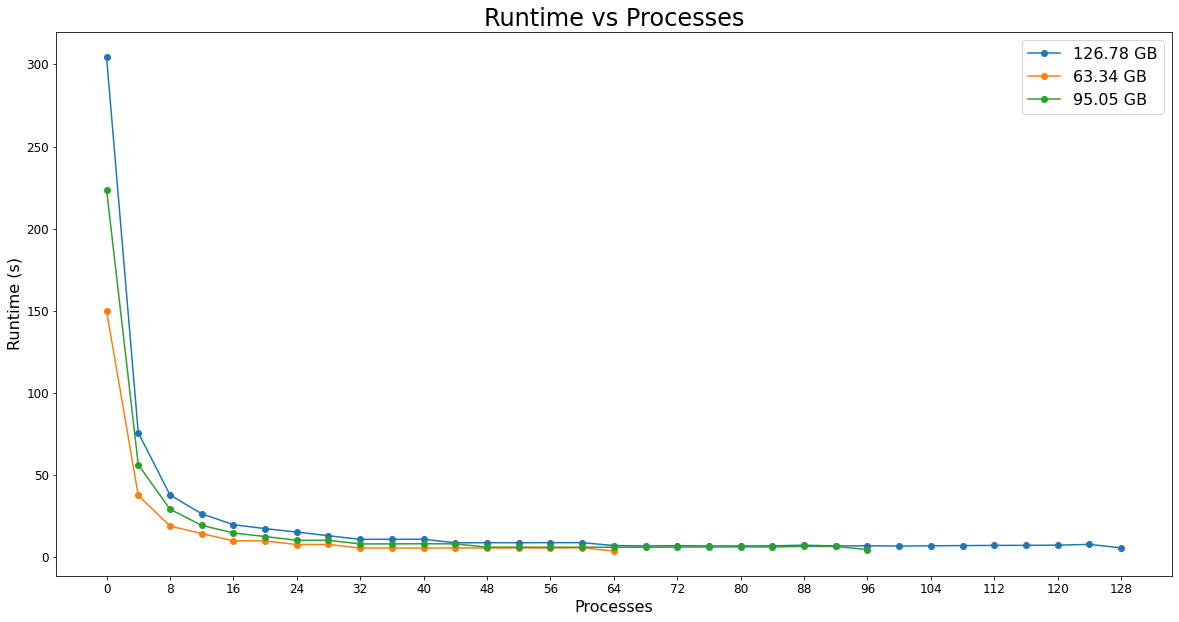

In [39]:
data = []
result_path = "runtime_tests_rdf/128_files/"
for file in sorted(os.listdir(result_path)):
    if file.endswith(".csv") and "runtime_vs_processes" in file:
        with open(result_path + file, "r") as f:
            data.append([[float(a) for a in row] for row in csv.reader(f)])
        
plt.figure(figsize = (20, 10))
plt.title('Runtime vs Processes', fontsize=24)
plt.xlabel('Processes', fontsize=16)
plt.ylabel('Runtime (s)', fontsize=16)
plt.xticks(range(0, 129, 8), fontsize=12)
plt.yticks(fontsize=12)
plt.plot(data[0][0], col_average(data[0][1:]), marker="o", label="%.2f GB" % (get_total_size(path, 128)))
plt.plot(data[1][0], col_average(data[1][1:]), marker="o", label="%.2f GB" % (get_total_size(path, 64)))
plt.plot(data[2][0], col_average(data[2][1:]), marker="o", label="%.2f GB" % (get_total_size(path, 96)))
plt.legend(prop={'size': 16})
plt.show()


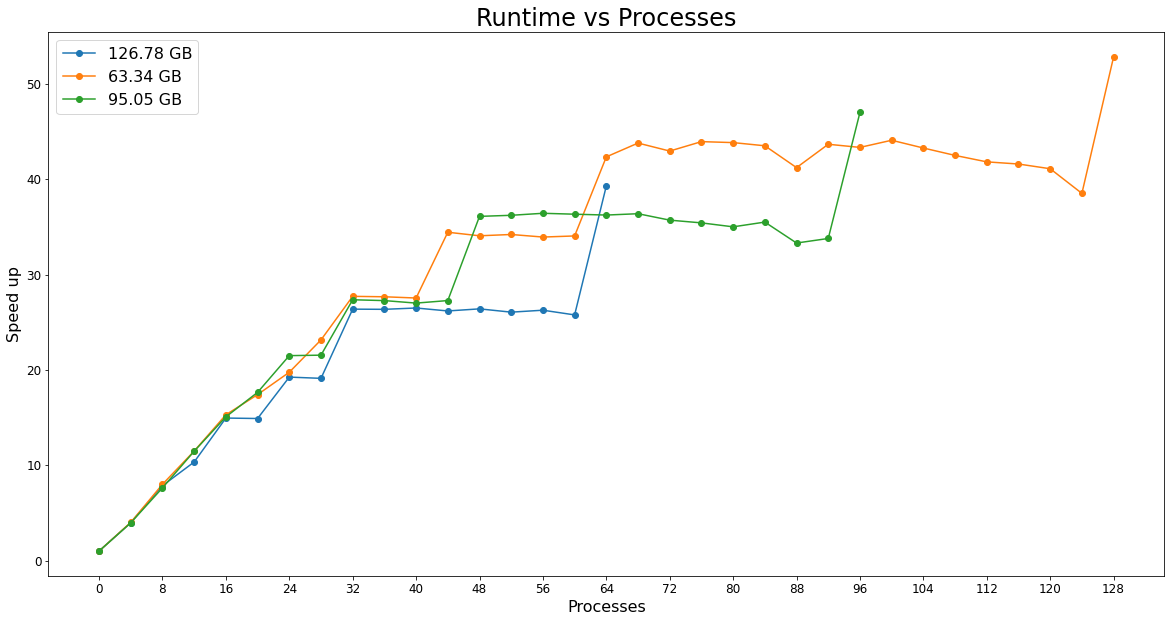

In [40]:
data = []
result_path = "runtime_tests_rdf/128_files/"
for file in os.listdir(result_path):
    if file.endswith(".csv") and "runtime_vs_processes" in file:
        with open(result_path + file, "r") as f:
            data.append([[float(a) for a in row] for row in csv.reader(f)])
        
plt.figure(figsize = (20, 10))
plt.title('Runtime vs Processes', fontsize=24)
plt.xlabel('Processes', fontsize=16)
plt.ylabel('Speed up', fontsize=16)
plt.xticks(range(0, 129, 8), fontsize=12)
plt.yticks(fontsize=12)
plt.plot(data[0][0], [col_average(data[0][1:])[0] / n for n in col_average(data[0][1:])], marker="o", label="%.2f GB" % (get_total_size(path, 128)))
plt.plot(data[1][0], [col_average(data[1][1:])[0] / n for n in col_average(data[1][1:])], marker="o", label="%.2f GB" % (get_total_size(path, 64)))
plt.plot(data[2][0], [col_average(data[2][1:])[0] / n for n in col_average(data[2][1:])], marker="o", label="%.2f GB" % (get_total_size(path, 96)))
plt.legend(prop={'size': 16})
plt.show()